# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [60]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import time
from tqdm import tqdm

In [61]:
!pip install torchsummary

Defaulting to user installation because normal site-packages is not writeable


In [62]:
!pip install ipywidgets

Defaulting to user installation because normal site-packages is not writeable


## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [63]:
# Define transforms
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                               ])


# Create training set and define training dataloader and validation dataloader
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)

indices_list = list(range(len(train_data)))
np.random.shuffle(indices_list)
split_index = int(0.9 * len(indices_list))
train_index = indices_list[: split_index]
valid_index = indices_list[split_index: ]

train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=128, sampler=valid_sampler)




# Create test set and define test dataloader
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle = True)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

transforms.ToTensor() is used to convert the images to tensor arrays (which speed up the computation) of 1 colour channel (Grayscale value between 0-255) . transforms.Normalize() is used to normalize the tensor with a mean and standard deviation passed as parameters. 

Also a validation set was created taking 10% from the training set.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [64]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])


In [65]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

 82%|████████▏ | 347/422 [01:28<00:19,  3.92it/s]


6


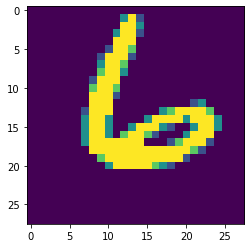

8


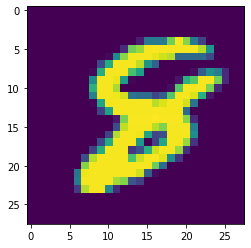

7


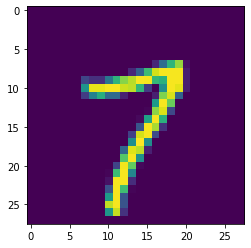

2


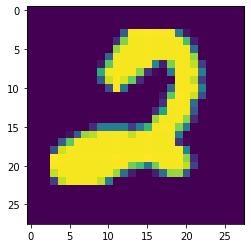

5


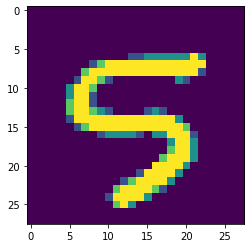

In [66]:
# Explore data
show5(train_loader)

In [67]:
print("Number of batches:")
print("Training dataset: ", len(train_loader))
print("Validation Dataset: ", len(valid_loader))
print("Test Dataset: ", len(test_loader))

Number of batches:
Training dataset:  422
Validation Dataset:  47
Test Dataset:  79


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [68]:
class ann_model(nn.Module):
    def __init__(self, num_classes=11):
        super(ann_model, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            
            
            nn.Linear(32, 10),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        out = torch.flatten(x, 1)      # flatten all dimensions except batch
        out = self.classifier(out)
        return out

In [69]:
# Adding a few convolution layers before fc layers for feature extraction

class cnn_model(nn.Module):
    def __init__(self, num_classes=11):
        super(cnn_model, self).__init__()
        self.convolutions = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace = True), 
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            
            
            nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace = True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            )

        self.classifier = nn.Sequential(
            nn.Linear(7*7*64, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            
            
            nn.Linear(32, 10),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        out = self.convolutions(x)
        out = out.reshape(out.size(0), -1)
        out = self.classifier(out)
        return out

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [70]:
def funct_criterion():
    criterion = nn.NLLLoss()
    return criterion


def funct_optimizer(my_model, alpha = 0.001):
    optimizer = optim.Adam(my_model.parameters(), alpha)
    return optimizer


def check_accuracy(model, dataloaders):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloaders:
            images, labels = data[0].to('cuda'), data[1].to('cuda')
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct/total

In [71]:
# Creating an instance of fully connected network model

model = ann_model().to('cuda')
print(model)

print()
print()
print()
print()



from torchsummary import summary
summary(model, (1, 28, 28))


del model

ann_model(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=64, out_features=32, bias=True)
    (13): ReLU()
    (14): Linear(in_features=32, out_features=10, bias=True)
    (15): LogSoftmax(dim=1)
  )
)




----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
              ReLU-2                  [-1, 512]               0
           Dropout-3                  [-1, 512]           

In [72]:
# Creating an instance of CNN model

model = cnn_model().to('cuda')
print(model)

print()
print()
print()
print()



from torchsummary import summary
summary(model, (1, 28, 28))


del model

cnn_model(
  (convolutions): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=Fal

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [73]:
def train_function(model, dataloaders_train, dataloaders_validate):
    
    print("TRAINING STARTED!!!!")
    start = time.time()
    
    
    train_loss = []
    train_acc = []
    validate_acc = []
    epoch = []

    for count in range(num_of_iterations):
    
        print("================================================================")
        print("Iteration --> {}/{} ".format(count+1, num_of_iterations), end = '\n')
        print("================================================================")
        
        running_loss = 0.0
        steps = 0
        
        for i, data in tqdm(enumerate(dataloaders_train), total=len(dataloaders_train)):
        
            steps += 1
            
            inputs, labels = data
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')
            optimizer.zero_grad()
        
            #Feeding forward
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            #Back-propagation
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
            tqdm._instances.clear()
            
        
        epoch.append(count+1)
        train_acc.append(round(check_accuracy(model, dataloaders_train), 4))
        validate_acc.append(round(check_accuracy(model, dataloaders_validate), 4))
        train_loss.append(running_loss/steps)
        print("Training loss: ", running_loss/steps)
        print("Training Accuracy: ", train_acc[-1])
        print("Validation Accuracy: ", validate_acc[-1])
        torch.cuda.empty_cache()


    print("TRAINING OVER!!!!")
    end = time.time()
    print("Training Time: ", (end - start)/60, " minutes")
    
    
    f = plt.figure()
    f.set_figwidth(10)
    f.set_figheight(5)
    plt.plot(epoch, train_acc, label = "Training Accuracy")
    plt.plot(epoch, validate_acc, label = "Validation Accuracy")
    plt.plot(epoch, train_loss, label = "Training Loss")
    plt.legend()
    plt.show()

  0%|          | 1/422 [00:00<00:52,  8.00it/s]

TRAINING STARTED!!!!
Iteration --> 1/20 


  0%|          | 1/422 [00:00<00:54,  7.67it/s]

Training loss:  0.8372898136411233
Training Accuracy:  0.8691
Validation Accuracy:  0.8697
Iteration --> 2/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.39901469895060027
Training Accuracy:  0.9001
Validation Accuracy:  0.9002
Iteration --> 3/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.3273533727638247
Training Accuracy:  0.9146
Validation Accuracy:  0.9122
Iteration --> 4/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.29375753813021555
Training Accuracy:  0.9243
Validation Accuracy:  0.9182
Iteration --> 5/20 


  0%|          | 1/422 [00:00<00:57,  7.29it/s]

Training loss:  0.2654849111557148
Training Accuracy:  0.9324
Validation Accuracy:  0.9265
Iteration --> 6/20 


  0%|          | 1/422 [00:00<00:55,  7.54it/s]

Training loss:  0.2510888422375889
Training Accuracy:  0.9272
Validation Accuracy:  0.9235
Iteration --> 7/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.23611452818905573
Training Accuracy:  0.9392
Validation Accuracy:  0.934
Iteration --> 8/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.22031112957163163
Training Accuracy:  0.9439
Validation Accuracy:  0.936
Iteration --> 9/20 


  0%|          | 1/422 [00:00<00:52,  8.00it/s]

Training loss:  0.21514099274907633
Training Accuracy:  0.9428
Validation Accuracy:  0.9373
Iteration --> 10/20 


  0%|          | 1/422 [00:00<00:52,  8.05it/s]

Training loss:  0.2076439520706074
Training Accuracy:  0.9406
Validation Accuracy:  0.9315
Iteration --> 11/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.1974568435154255
Training Accuracy:  0.9491
Validation Accuracy:  0.9442
Iteration --> 12/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.1915473721179917
Training Accuracy:  0.9479
Validation Accuracy:  0.946
Iteration --> 13/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.1864483755134858
Training Accuracy:  0.9494
Validation Accuracy:  0.9432
Iteration --> 14/20 


  0%|          | 1/422 [00:00<00:44,  9.43it/s]

Training loss:  0.18320045932703674
Training Accuracy:  0.9519
Validation Accuracy:  0.9457
Iteration --> 15/20 


  0%|          | 1/422 [00:00<00:55,  7.60it/s]

Training loss:  0.17602713450224478
Training Accuracy:  0.9551
Validation Accuracy:  0.946
Iteration --> 16/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.17630193713540432
Training Accuracy:  0.95
Validation Accuracy:  0.9427
Iteration --> 17/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.17044309369548802
Training Accuracy:  0.9514
Validation Accuracy:  0.9453
Iteration --> 18/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.16682806095964678
Training Accuracy:  0.9568
Validation Accuracy:  0.9513
Iteration --> 19/20 


  0%|          | 1/422 [00:00<00:58,  7.21it/s]

Training loss:  0.1602747983374231
Training Accuracy:  0.9564
Validation Accuracy:  0.9515
Iteration --> 20/20 


100%|██████████| 422/422 [00:17<00:00, 23.58it/s]


Training loss:  0.1576374004202149
Training Accuracy:  0.9574
Validation Accuracy:  0.9507
TRAINING OVER!!!!
Training Time:  11.514337921142578  minutes


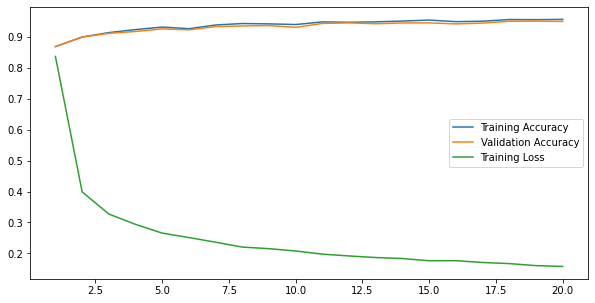

In [75]:
model1 = ann_model().to('cuda')
criterion = funct_criterion()
optimizer = funct_optimizer(model1, alpha = 0.001)


num_of_iterations = 20
train_function(model1, train_loader, valid_loader)

  0%|          | 0/422 [00:00<?, ?it/s]

TRAINING STARTED!!!!
Iteration --> 1/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.596943044726035
Training Accuracy:  0.9669
Validation Accuracy:  0.9637
Iteration --> 2/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.11956051833292036
Training Accuracy:  0.9766
Validation Accuracy:  0.9748
Iteration --> 3/20 


  0%|          | 1/422 [00:00<01:00,  7.00it/s]

Training loss:  0.08726854496789982
Training Accuracy:  0.9797
Validation Accuracy:  0.9807
Iteration --> 4/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.0697353628709012
Training Accuracy:  0.9836
Validation Accuracy:  0.9817
Iteration --> 5/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.061496247642263066
Training Accuracy:  0.9864
Validation Accuracy:  0.9842
Iteration --> 6/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.04877583865932591
Training Accuracy:  0.9895
Validation Accuracy:  0.9857
Iteration --> 7/20 


  0%|          | 1/422 [00:00<01:04,  6.54it/s]

Training loss:  0.0451841245520412
Training Accuracy:  0.9894
Validation Accuracy:  0.986
Iteration --> 8/20 


  0%|          | 1/422 [00:00<01:03,  6.60it/s]

Training loss:  0.04153015759334374
Training Accuracy:  0.9914
Validation Accuracy:  0.987
Iteration --> 9/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.03503971967431805
Training Accuracy:  0.9917
Validation Accuracy:  0.9867
Iteration --> 10/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.03246221497326083
Training Accuracy:  0.9921
Validation Accuracy:  0.9847
Iteration --> 11/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.03031614959832795
Training Accuracy:  0.9944
Validation Accuracy:  0.989
Iteration --> 12/20 


  0%|          | 1/422 [00:00<01:12,  5.83it/s]

Training loss:  0.029772776044669044
Training Accuracy:  0.9961
Validation Accuracy:  0.9905
Iteration --> 13/20 


  0%|          | 1/422 [00:00<01:15,  5.54it/s]

Training loss:  0.023432313525375868
Training Accuracy:  0.995
Validation Accuracy:  0.9897
Iteration --> 14/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.02383394293565073
Training Accuracy:  0.9945
Validation Accuracy:  0.9878
Iteration --> 15/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.02013670466216121
Training Accuracy:  0.9959
Validation Accuracy:  0.9907
Iteration --> 16/20 


  0%|          | 1/422 [00:00<01:03,  6.59it/s]

Training loss:  0.021351448028072244
Training Accuracy:  0.9947
Validation Accuracy:  0.9905
Iteration --> 17/20 


  0%|          | 1/422 [00:00<01:00,  6.99it/s]

Training loss:  0.018330635495451598
Training Accuracy:  0.9961
Validation Accuracy:  0.9882
Iteration --> 18/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.01989856466120059
Training Accuracy:  0.9969
Validation Accuracy:  0.9895
Iteration --> 19/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.018072334468019608
Training Accuracy:  0.9966
Validation Accuracy:  0.9897
Iteration --> 20/20 


100%|██████████| 422/422 [00:26<00:00, 15.98it/s]


Training loss:  0.016334835141726855
Training Accuracy:  0.9964
Validation Accuracy:  0.9912
TRAINING OVER!!!!
Training Time:  15.194056208928426  minutes


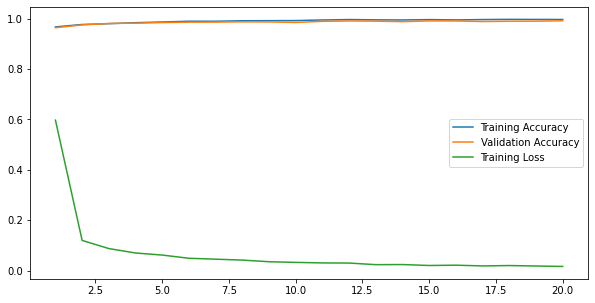

In [76]:
model2 = cnn_model().to('cuda')
criterion = funct_criterion()
optimizer = funct_optimizer(model2, alpha = 0.001)


num_of_iterations = 20
train_function(model2, train_loader, valid_loader)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [77]:
ans = check_accuracy(model1, test_loader)
print("Network Accuracy on the Test Dataset for the ANN model = ", round(ans*100, 4), "%")

Network Accuracy on the Test Dataset for the ANN model =  95.27 %


In [78]:
ans = check_accuracy(model2, test_loader)
print("Network Accuracy on the Test Dataset for the CNN model = ", round(ans*100, 4), "%")

Network Accuracy on the Test Dataset for the CNN model =  99.04 %


In [79]:
del model1
del model2

## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

#### Here, I have tried to see if without normalizations, the two models perform slightly better.....

In [80]:
# Define transforms
transform = transforms.Compose([transforms.ToTensor()])


# Create training set and define training dataloader and validation dataloader
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)

indices_list = list(range(len(train_data)))
np.random.shuffle(indices_list)
split_index = int(0.9 * len(indices_list))
train_index = indices_list[: split_index]
valid_index = indices_list[split_index: ]

train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=128, sampler=valid_sampler)




# Create test set and define test dataloader
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle = True)

  0%|          | 0/422 [00:00<?, ?it/s]

TRAINING STARTED!!!!
Iteration --> 1/20 


  0%|          | 2/422 [00:00<00:29, 14.29it/s]

Training loss:  0.5954934659091782
Training Accuracy:  0.9245
Validation Accuracy:  0.9237
Iteration --> 2/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.23459319968076678
Training Accuracy:  0.9482
Validation Accuracy:  0.9385
Iteration --> 3/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.17844681039240687
Training Accuracy:  0.9542
Validation Accuracy:  0.9437
Iteration --> 4/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.15285471039802118
Training Accuracy:  0.9627
Validation Accuracy:  0.9535
Iteration --> 5/20 


  0%|          | 2/422 [00:00<00:29, 14.13it/s]

Training loss:  0.1352937888151026
Training Accuracy:  0.9661
Validation Accuracy:  0.9555
Iteration --> 6/20 


  0%|          | 1/422 [00:00<00:51,  8.24it/s]

Training loss:  0.12551127623554795
Training Accuracy:  0.9693
Validation Accuracy:  0.955
Iteration --> 7/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.10981414832121812
Training Accuracy:  0.9708
Validation Accuracy:  0.9603
Iteration --> 8/20 


  0%|          | 1/422 [00:00<01:21,  5.14it/s]

Training loss:  0.1022878502786901
Training Accuracy:  0.9744
Validation Accuracy:  0.9657
Iteration --> 9/20 


  0%|          | 1/422 [00:00<01:20,  5.24it/s]

Training loss:  0.09901046381283428
Training Accuracy:  0.9737
Validation Accuracy:  0.9613
Iteration --> 10/20 


  0%|          | 1/422 [00:00<00:49,  8.43it/s]

Training loss:  0.09183591556894236
Training Accuracy:  0.9775
Validation Accuracy:  0.9662
Iteration --> 11/20 


  0%|          | 1/422 [00:00<00:43,  9.65it/s]

Training loss:  0.08625410263254461
Training Accuracy:  0.9794
Validation Accuracy:  0.9652
Iteration --> 12/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.08141500586246568
Training Accuracy:  0.978
Validation Accuracy:  0.9617
Iteration --> 13/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.07970356729578985
Training Accuracy:  0.9785
Validation Accuracy:  0.9628
Iteration --> 14/20 


  0%|          | 1/422 [00:00<00:50,  8.39it/s]

Training loss:  0.07535820441227847
Training Accuracy:  0.9799
Validation Accuracy:  0.9678
Iteration --> 15/20 


  0%|          | 1/422 [00:00<00:50,  8.28it/s]

Training loss:  0.07382649822729988
Training Accuracy:  0.98
Validation Accuracy:  0.9677
Iteration --> 16/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.06637439917512591
Training Accuracy:  0.9804
Validation Accuracy:  0.967
Iteration --> 17/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.06881233921574685
Training Accuracy:  0.9812
Validation Accuracy:  0.9658
Iteration --> 18/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.06212947137987074
Training Accuracy:  0.9834
Validation Accuracy:  0.968
Iteration --> 19/20 


  0%|          | 1/422 [00:00<00:59,  7.11it/s]

Training loss:  0.060530834666881445
Training Accuracy:  0.9825
Validation Accuracy:  0.965
Iteration --> 20/20 


100%|██████████| 422/422 [00:11<00:00, 36.61it/s]


Training loss:  0.06207939843267591
Training Accuracy:  0.9851
Validation Accuracy:  0.9687
TRAINING OVER!!!!
Training Time:  7.319828097025553  minutes


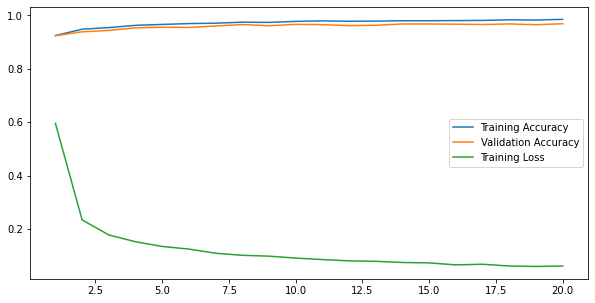

In [81]:
model1 = ann_model().to('cuda')
criterion = funct_criterion()
optimizer = funct_optimizer(model1, alpha = 0.001)


num_of_iterations = 20
train_function(model1, train_loader, valid_loader)

  0%|          | 0/422 [00:00<?, ?it/s]

TRAINING STARTED!!!!
Iteration --> 1/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.6023654060888488
Training Accuracy:  0.9617
Validation Accuracy:  0.9607
Iteration --> 2/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.12868107415038332
Training Accuracy:  0.979
Validation Accuracy:  0.9743
Iteration --> 3/20 


  0%|          | 1/422 [00:00<00:58,  7.16it/s]

Training loss:  0.09096099314019437
Training Accuracy:  0.9817
Validation Accuracy:  0.9793
Iteration --> 4/20 


  0%|          | 1/422 [00:00<00:59,  7.11it/s]

Training loss:  0.0719670783778017
Training Accuracy:  0.9851
Validation Accuracy:  0.9813
Iteration --> 5/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.06362053370809456
Training Accuracy:  0.9886
Validation Accuracy:  0.984
Iteration --> 6/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.052427770073914026
Training Accuracy:  0.9884
Validation Accuracy:  0.9838
Iteration --> 7/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.04760317474336615
Training Accuracy:  0.9833
Validation Accuracy:  0.9782
Iteration --> 8/20 


  0%|          | 1/422 [00:00<01:02,  6.71it/s]

Training loss:  0.044357990479274426
Training Accuracy:  0.9914
Validation Accuracy:  0.9878
Iteration --> 9/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.03658986286912886
Training Accuracy:  0.9914
Validation Accuracy:  0.9867
Iteration --> 10/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.037108974268117045
Training Accuracy:  0.9936
Validation Accuracy:  0.988
Iteration --> 11/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.0308711008294
Training Accuracy:  0.993
Validation Accuracy:  0.9855
Iteration --> 12/20 


  0%|          | 1/422 [00:00<01:05,  6.44it/s]

Training loss:  0.02846038237369125
Training Accuracy:  0.9939
Validation Accuracy:  0.9873
Iteration --> 13/20 


  0%|          | 1/422 [00:00<00:56,  7.49it/s]

Training loss:  0.029024351707944356
Training Accuracy:  0.994
Validation Accuracy:  0.9875
Iteration --> 14/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.024253593160223515
Training Accuracy:  0.9954
Validation Accuracy:  0.9892
Iteration --> 15/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.021300890375857275
Training Accuracy:  0.9946
Validation Accuracy:  0.9892
Iteration --> 16/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.024607447071007277
Training Accuracy:  0.995
Validation Accuracy:  0.9873
Iteration --> 17/20 


  0%|          | 1/422 [00:00<00:57,  7.35it/s]

Training loss:  0.02129553273084747
Training Accuracy:  0.9955
Validation Accuracy:  0.9867
Iteration --> 18/20 


  0%|          | 1/422 [00:00<01:00,  6.99it/s]

Training loss:  0.020867785845831602
Training Accuracy:  0.9954
Validation Accuracy:  0.9885
Iteration --> 19/20 


  0%|          | 0/422 [00:00<?, ?it/s]

Training loss:  0.018864597595212387
Training Accuracy:  0.996
Validation Accuracy:  0.9883
Iteration --> 20/20 


100%|██████████| 422/422 [00:19<00:00, 21.73it/s]


Training loss:  0.016806222199447458
Training Accuracy:  0.9957
Validation Accuracy:  0.9867
TRAINING OVER!!!!
Training Time:  10.763115835189819  minutes


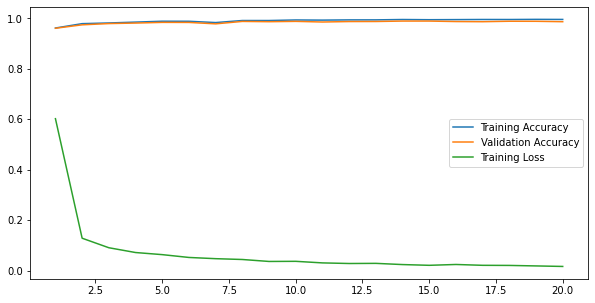

In [82]:
model2 = cnn_model().to('cuda')
criterion = funct_criterion()
optimizer = funct_optimizer(model2, alpha = 0.001)


num_of_iterations = 20
train_function(model2, train_loader, valid_loader)

In [83]:
# Re-testing the models....

ans = check_accuracy(model1, test_loader)
print("Network Accuracy on the Test Dataset for the ANN model = ", round(ans*100, 4), "%")

ans = check_accuracy(model2, test_loader)
print("Network Accuracy on the Test Dataset for the CNN model = ", round(ans*100, 4), "%")

Network Accuracy on the Test Dataset for the ANN model =  96.91 %
Network Accuracy on the Test Dataset for the CNN model =  98.75 %


## Sanity Checking

Predicted Digit = 6


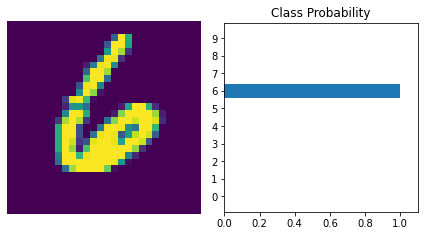

In [101]:
# With the ANN model

with torch.no_grad():
    images, labels = next(iter(test_loader))
    images, labels = images.to('cuda'), labels.to('cuda')
    img = images[0].view(1, 784)

    logps = model1(img)           # log-probabilities
    ps = torch.exp(logps)         # probabilities

    probab = list(ps.cpu().numpy()[0])
    print("Predicted Digit =", probab.index(max(probab)))

    ps = ps.cpu().data.numpy().squeeze()
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).cpu().numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

## Saving your model
Using `torch.save`, save your model for future loading.

In [106]:
## YOUR CODE HERE ##

torch.save(model1, './ann_model.pt') 
torch.save(model2, './cnn_model.pt') 